# Biblioteki

In [59]:
import random
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import glob
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc
from itertools import islice
from tensorflow.keras.preprocessing.image import  img_to_array, load_img
from skimage.transform import resize
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import datetime
from sklearn.model_selection import train_test_split



# Przygotowanie danych wejściowych

In [ ]:
w, h = 512 ,512
border = 5

In [ ]:

train = sorted(glob.glob("/content/drive/MyDrive/SegSperm/train/images/*"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/SegSperm/train/GT1_full/*.png"))
test = sorted(glob.glob("/content/drive/MyDrive/SegSperm/test/images/*"))
test_mask = sorted(glob.glob("/content/drive/MyDrive/SegSperm/test/GT1_full/*.png"))
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')
print(f'Total Test Images : {len(test)}\nTotal Test Mask Image : {len(test_mask)}')

Total Train Images : 432
Total Mask Image : 432
Total Test Images : 119
Total Test Mask Image : 119


In [ ]:
X_train = np.zeros((len(train), h, w,3), dtype=np.float32)
y_train = np.zeros((len(train_mask), h, w,1), dtype=np.float32)
X_test = np.zeros((len(test), h, w,3), dtype=np.float32)
y_test = np.zeros((len(test_mask), h, w,1), dtype=np.float32)

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(train, train_mask))):
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w,3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w,1), mode = 'constant', preserve_range = True)
  # # Save images
  X_train[n] = x_img/255.0
  y_train[n] = mask/255.0

0it [00:00, ?it/s]

In [ ]:
for n, (img, mimg) in tqdm(enumerate(zip(test, test_mask))):
  # Load images
  img = load_img(img)
  x_img = img_to_array(img)
  x_img = resize(x_img, (h, w,3), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = img_to_array(load_img(mimg, color_mode = "grayscale"))
  mask = resize(mask, (h, w,1), mode = 'constant', preserve_range = True)
  # # Save images
  X_test[n] = x_img/255.0
  y_test[n] = mask/255.0

119it [00:57,  2.08it/s]


In [ ]:
#np.save('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandY/X.npy'', X_train)
#np.save('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandY/y.npy', y_train)
#np.save('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandYTest/X_test.npy', X_test)
#np.save('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandYTest/y_test.npy', y_test)

In [3]:
X_train = np.load('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandY/X.npy')
y_train = np.load('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandY/y.npy')
X_test = np.load('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandYTest/X_test.npy')
y_test = np.load('/media/cal314-1/9E044F59044F3415/Marcin/Data/XandYTest/y_test.npy')

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [5]:
print("train_images shape and range", y_train.shape, y_train.min(), y_train.max())
print("val_images shape and range", y_val.shape, y_val.min(), y_val.max())
print("val_masks shape and range", y_test.shape, y_test.min(), y_test.max())

train_images shape and range (388, 512, 512, 1) 0.0 1.0
val_images shape and range (44, 512, 512, 1) 0.0 1.0
val_masks shape and range (119, 512, 512, 1) 0.0 1.0


## Pytorch

In [6]:
y_train = np.transpose(y_train, (0, 3, 1, 2))
y_val = np.transpose(y_val, (0, 3, 1, 2))
y_test = np.transpose(y_test, (0, 3, 1, 2))

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))


X_train_tensor = torch.from_numpy(X_train)  
y_train_tensor = torch.from_numpy(y_train)

y_val_tensor = torch.from_numpy(y_val) 
X_val_tensor = torch.from_numpy(X_val)  

X_test_tensor = torch.from_numpy(X_test)  
y_test_tensor = torch.from_numpy(y_test)  

# Tworzenie obiektów TensorDataset na podstawie tensorów danych treningowych i testowych
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Tworzenie DataLoader dla danych treningowych i testowych
batch_size = 6  # Rozmiar mini-batcha
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle=True)

In [7]:
print("X_train_tensor shape and range", X_train_tensor.shape, X_train_tensor.min(), X_train_tensor.max())
print("y_train_tensor shape and range", y_train_tensor.shape, y_train_tensor.min(), y_train_tensor.max())
print("X_val_tensor shape and range", X_val_tensor.shape, X_val_tensor.min(), X_val_tensor.max())
print("y_val_tensor shape and range", y_val_tensor.shape, y_val_tensor.min(), y_val_tensor.max())
print("X_test_tensor shape and range", X_test_tensor.shape, X_test_tensor.min(), X_test_tensor.max())
print("y_test_tensor shape and range", y_test_tensor.shape, y_test_tensor.min(), y_test_tensor.max())
gc.collect()

X_train_tensor shape and range torch.Size([388, 3, 512, 512]) tensor(0.0078) tensor(1.)
y_train_tensor shape and range torch.Size([388, 1, 512, 512]) tensor(0.) tensor(1.)
X_val_tensor shape and range torch.Size([44, 3, 512, 512]) tensor(0.0353) tensor(0.8627)
y_val_tensor shape and range torch.Size([44, 1, 512, 512]) tensor(0.) tensor(1.)
X_test_tensor shape and range torch.Size([119, 3, 512, 512]) tensor(0.0392) tensor(1.)
y_test_tensor shape and range torch.Size([119, 1, 512, 512]) tensor(0.) tensor(1.)


532

# Wyświetlenie danych wejściowych

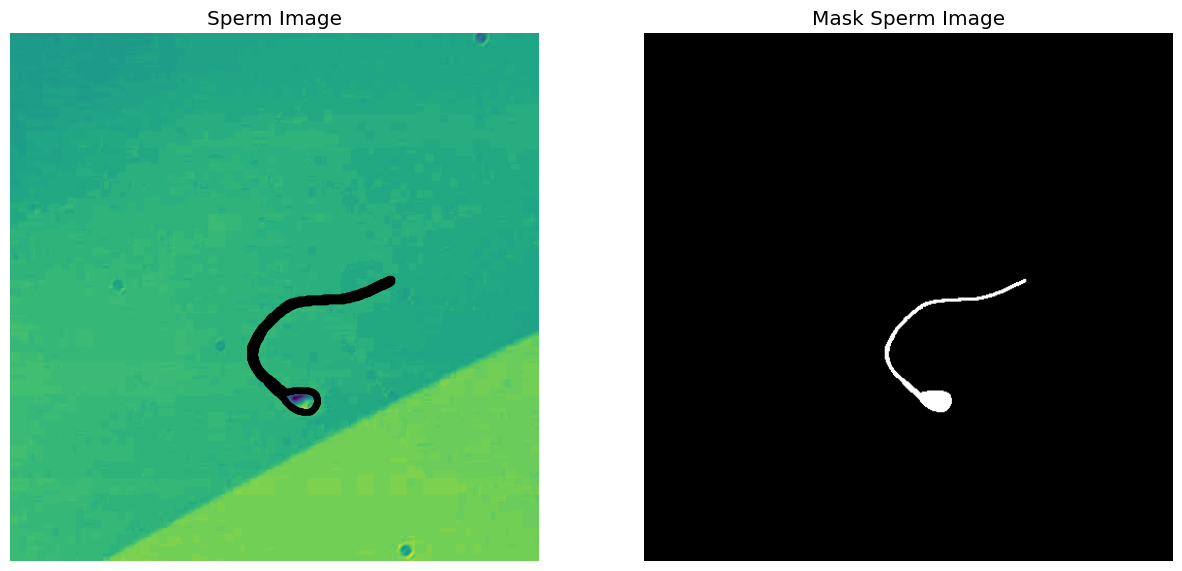

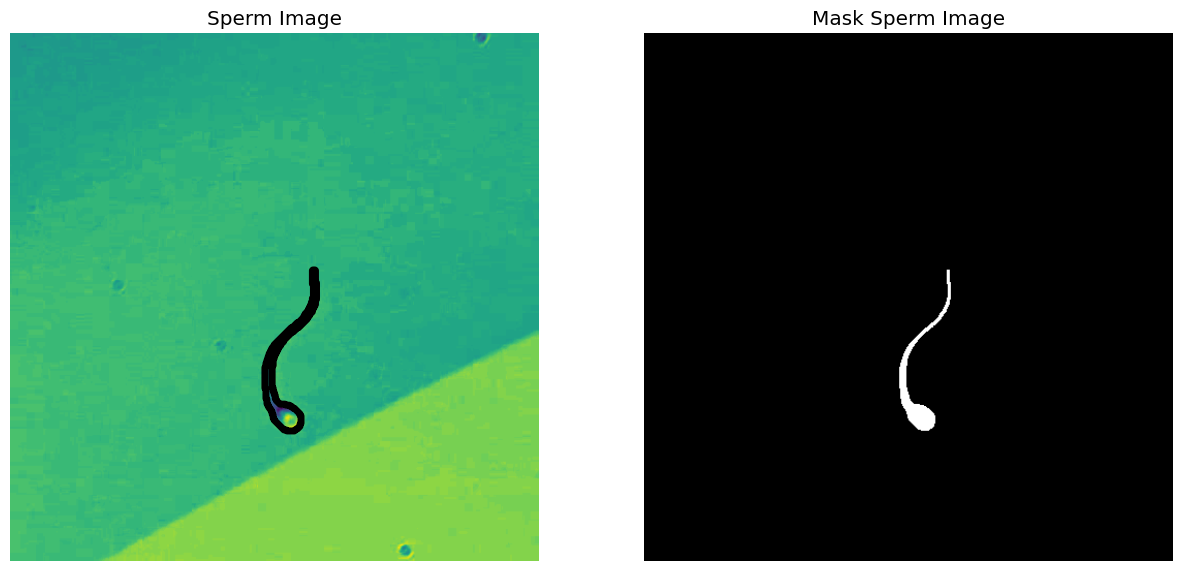

In [8]:

target = val_loader

for batch in islice(target, 2):  
    image, mask = batch
    image = np.transpose(image, (0, 2, 3, 1))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    ax1.imshow(image[0,...,0].squeeze(), interpolation='bilinear')
    ax1.contour(mask[0].squeeze(), colors='k', linewidths=5, levels=[0.5])
    ax1.set_title('Sperm Image')
    ax1.set_axis_off()

    ax2.imshow(mask[0].squeeze(), cmap='gray', interpolation='bilinear')
    ax2.set_title('Mask Sperm Image')
    ax2.set_axis_off()


# Definiowanie modelu

In [9]:
""" Parts of the U-Net model """

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [10]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        output = torch.sigmoid(logits)
        return output

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# Trening modelu

In [11]:
# Sprawdź dostępność GPU
if torch.cuda.is_available():
    # Pobierz nazwę karty GPU
    gpu_name = torch.cuda.get_device_name(0)  # 0 oznacza pierwszą dostępną kartę GPU

    print("GPU dostępne:", gpu_name)
else:
    print("Brak dostępnej karty GPU. Obliczenia będą wykonywane na CPU.")


GPU dostępne: NVIDIA GeForce RTX 3090


In [71]:

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = UNet(3,1)
model.to(device)
loss_fn = nn.BCELoss()

# Definicja optymalizatora (np. Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [73]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    batches = len(train_loader)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if batch_idx % batches == batches - 1 or (batch_idx + 1) % 10 == 0:
            last_loss = running_loss / batches # loss per batch
            print('  batch {} loss: {}'.format(batch_idx + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + batch_idx + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [124]:
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/noisy_labels_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

# Early stopping
last_loss = 1_000_000.
patience = 20
trigger_times = 0

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for batch_idx, (vinputs, vlabels) in enumerate(train_loader):
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    
    last_avg_vloss = avg_vloss
    avg_vloss = running_vloss / (batch_idx + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    scheduler.step(avg_vloss)
    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = '/media/cal314-1/9E044F59044F3415/Marcin/Data/model/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    #Early stopping
    if avg_vloss > last_avg_vloss:
        trigger_times += 1
        print('Trigger Times:', trigger_times)
    if trigger_times > patience:
        print('Early stopping!\nStart to test process.')
        break


    epoch_number += 1

EPOCH 1:
  batch 10 loss: 0.0010467226402117655
  batch 20 loss: 0.0011739205569028855
  batch 30 loss: 0.0009400687968501678
  batch 40 loss: 0.0009175113473947232
  batch 50 loss: 0.001051280812288706
  batch 60 loss: 0.0009794863155828072
  batch 65 loss: 0.000543030587813029
LOSS train 0.000543030587813029 valid 0.006574008148163557
EPOCH 2:
  batch 10 loss: 0.0009354950501941718
  batch 20 loss: 0.0011685578654018732
  batch 30 loss: 0.000982940189826947
  batch 40 loss: 0.0009516426791938452
  batch 50 loss: 0.000931533626638926
  batch 60 loss: 0.0011050104020306696
  batch 65 loss: 0.0005612917960836337
LOSS train 0.0005612917960836337 valid 0.0065695312805473804
EPOCH 3:
  batch 10 loss: 0.0009403641478946575
  batch 20 loss: 0.0010775310059006398
  batch 30 loss: 0.0009651966607914521
  batch 40 loss: 0.0010475086979568004
  batch 50 loss: 0.000995449019739261
  batch 60 loss: 0.0010438561296233764
  batch 65 loss: 0.0005709275746574768
LOSS train 0.0005709275746574768 valid 

In [125]:
!tensorboard --logdir=runs

2023-10-27 16:09:48.827043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 16:09:48.846306: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 16:09:48.846328: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 16:09:48.846344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 16:09:48.850126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 16:09:48.850249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [126]:
model = UNet(3,1)
model.load_state_dict(torch.load('/media/cal314-1/9E044F59044F3415/Marcin/Data/model/model_20231027_153954_4'))
model.eval()  

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

# Test modelu

In [127]:

model.to(device)
model.eval() 

# Listy do przechowywania obrazów wejściowych, predykcji i etykiet 
input_images = []
predicted_masks = []
true_masks = []  

# Pętla do przewidywania na danych testowych
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

    
        input_images.append(inputs.cpu())
        predicted_masks.append(outputs.cpu())
        true_masks.append(labels.cpu())  

input_images = np.concatenate(input_images, axis=0)
true_masks = np.concatenate(true_masks, axis=0)  # Jeśli etykiety są w formie listy lub tensora
predicted_masks = torch.cat(predicted_masks, dim=0).cpu().numpy()  # Jeśli predykcje są w tensorach PyTorch



In [76]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sperm Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Sperm Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Sperm Image Predicted')
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    #if has_mask:
        #ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Sperm Mask Image Predicted binary');
    ax[3].set_axis_off()

In [86]:
# Threshold predictions
x_images = input_images.transpose((0, 2, 3, 1))
true = true_masks.reshape(119, 512, 512)
pred = predicted_masks.reshape(119, 512, 512)

threshold = 0.5
true_masks_t = (true > threshold).astype(np.uint8)
predicted_masks_t = (pred > threshold).astype(np.uint8)

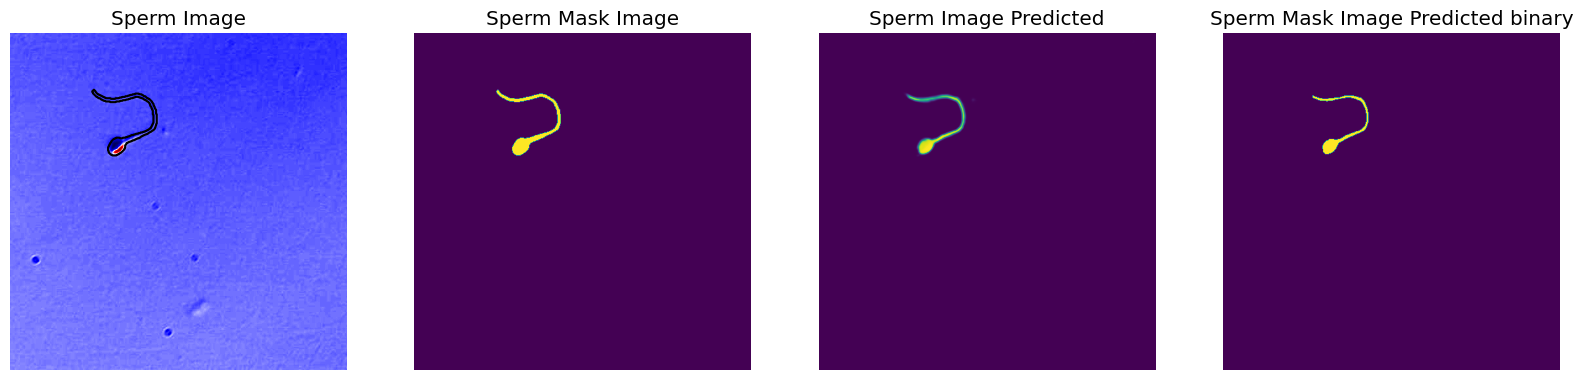

In [142]:
plot_sample(x_images, true_masks_t, pred, predicted_masks_t)

In [129]:
IoU = jaccard_score(true_masks_t.flatten(), predicted_masks_t.flatten())
average_precision = average_precision_score(true_masks_t.flatten(), predicted_masks_t.flatten())

print("IoU: {}".format(IoU))
print("Average Precision: {}".format(average_precision))

IoU: 0.48054968822687294
Average Precision: 0.4322148346038248
